### This Colab provides a minimal implementation of the TrajeDi algorithm.

The colab runs in approx. 3 minutes and outputs one of the plots in the paper.

In [1]:
import torch

from torch.nn import init
from torch.optim import Adam
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from time import time

# Define methods




In [2]:
def entropy(pi):
    """
    Get policy entropy
    :param pi: Probability matrix
    :return: entropy
    """
    return -(torch.log(pi)*pi).sum()

def get_theta(dims, std_val):
    return init.normal_(torch.zeros(dims[0], dims[1], requires_grad=True), std=std_val)


def get_thetas(n_dim, one_step, std_val=0.01):
    """
    Get policy parametrization. In the one_step game, Joint Action Learning (JAL) is used.
    :return: List of the thetas, i.e. [theta] for the One Step setting using JAL and [theta1, theta2] for the Two Step setting
    """
    if one_step:
        dims1 = [n_dim, 1]          # p(a^1), p(a^2), of size N x 1
        dims2 = [n_dim, 1]
    else:
        dims1 = [n_dim, 1]          # p(a^1), of size N x 1
        dims2 = [n_dim, n_dim]      # p(a^2|a^1), of size N x N

    theta1 = get_theta(dims1, std_val)
    theta2 = get_theta(dims2, std_val)

    return [theta1, theta2]

def train_mult_seeds(n_seeds, pops, t_max, t_add, payoff_matrix, lr=0.05, div_factor = 1):
    """
    Train (n_seeds) populations of agents sequentially, each with a BR. Evaluate BR self-play and inter-BR cross-play
    TODO: add stopping criterion. Currently requires the population size.
    :param t_max: training time since last added policy
    :param t_add: number of steps after which to add another policy
    """
    n_dim = payoff_matrix.shape[0]
    one_step = True


    # Pools
    pools = []

    for s in range(n_seeds):

        policies = [get_thetas(n_dim, one_step)]  # Index 0 is best response
        for i in range(pops):
            policies.append(get_thetas(n_dim, one_step))  # "Regular" policies

        pools.append(policies)

    training_length = t_add * (pops - 1) + t_max  # Wait t_add before adding each policy + t_max after the last


    # BR self-plays and inter-BR cross-plays
    BR_SP = np.zeros( (n_seeds, training_length) )
    BR_XP = np.zeros( (n_seeds*(n_seeds-1), training_length) )

    returns = np.zeros((pops + 1, training_length))
    BR_plays = np.zeros((pops + 1, training_length))

    optimizers = [[[Adam([par], lr=lr) for par in thetas] for thetas in policies] for policies in pools]

    active_pops = 0 if t_add > 0 else pops

    for i in range(training_length):

        for pool_idx, policies in enumerate(pools):

            if t_add > 0 and i % t_add == 0 and active_pops < pops:
                active_pops += 1  # Grow population

            loss = 0
            avg_entropy = 0  # average of entropies H(pi_i), except BR
            avg_policy = torch.zeros((n_dim, n_dim))  # average of all policies except BR

            for pop in range(active_pops + 1):
                for opt in optimizers[pool_idx][pop]:
                    opt.zero_grad()

            for pop in range(active_pops + 1):
                rewards, losses, SP_prob_matrix = get_objective(policies[pop], payoff_matrix, return_probs=True)

                # Log BR SP
                if pop == 0:
                    BR_SP[pool_idx, i] = rewards[0]

                # policy_losses[pop] += losses[0]
                loss += losses[0]

                # Get BR-p_BRlay loss: J(BR, pi_i)
                if pop != 0:
                    BR_rewards, BR_losses, BR_prob_matrix_A = evaluate(policies[pop], policies[0], payoff_matrix,
                                                                       return_losses=True, return_probs=True)
                    loss += BR_losses[0]

                    BR_rewards, BR_losses, BR_prob_matrix_B = evaluate(policies[0], policies[pop], payoff_matrix,
                                                                       return_losses=True, return_probs=True)
                    loss += BR_losses[0]

                    prob_matrix = SP_prob_matrix

                    avg_entropy += entropy(prob_matrix.reshape([-1]))
                    avg_policy += prob_matrix

                    # Log performance
                    BR_plays[pop, i] = BR_rewards[0].data.numpy()  # Play with BR
                returns[pop, i] = rewards[0].data.numpy()  # Self-play

            avg_entropy = avg_entropy / pops
            avg_policy = avg_policy / pops
            entropy_of_avg = entropy(avg_policy.reshape([-1]))  # entropy of average policy

            JSD = (entropy_of_avg - avg_entropy)

            loss -= div_factor * JSD

            loss.backward()

            for pop in range(active_pops + 1):
                for opt in optimizers[pool_idx][pop]:
                    opt.step()

        BR_XP[:,i] = eval_all_XP([policies[0] for policies in pools], payoff_matrix)

    return BR_SP, BR_XP, pools

def get_objective(thetas, payoff_matrix, eval_mode=False, return_probs=False):
    """
    Run one play of the levers game (one episode)
    :param thetas: policy parameters
    :param payoff_matrix: payoffs of the matrix game
    :param l_pen: scaling of the entropy-based penalty (entropy regularization?)
    :param one_step: Single step matrix game. Uses joint action learning
    :param return_probs: if True, also returns the joint probability matrix (default: False)
    :return: expected returns (1 per agent, equal), losses (1 per agent, equal, includes entropy term)
    """
    one_step = True
    if one_step:
        thetas_1 = thetas[0]
        thetas_2 = thetas[1]
        p1 = torch.softmax(thetas_1, 0)
        p2 = torch.softmax(thetas_2, 0)

        p_s_comma_a = p1.matmul(torch.reshape(p2, [1, -1]))

    ent = entropy(p_s_comma_a.reshape([-1]))
    r1 = (p_s_comma_a * payoff_matrix).sum()
    r2 = r1
    rewards = [r1, r2]
    l1 = -r1

    # p1_ent = entropy(p1.reshape([-1]))        # Uncomment to have Agent 2 minimize conditional entropy
    # cond_ent = ent - p1_ent
    # l2 = -(r2 - cond_ent * 0.02)

    l2 = l1
    losses = [l1, l2]
    if return_probs:
        return rewards, losses, p_s_comma_a
    return rewards, losses, {}


def eval_all_XP(best_responses, payoff_matrix):

    N = len(best_responses)
    XP_scores = np.zeros(N*(N-1))

    with torch.no_grad():
        idx = 0
        for i in range(N):
            for j in range(N):
                # XP all pairs, (BR_i, BR_j) and (BR_j, BR_i)

                if i == j:
                    continue

                XP_scores[idx] = evaluate(best_responses[i], best_responses[j], payoff_matrix)
                idx +=1

    return XP_scores

def evaluate(policy_0, policy_1, payoff_matrix, return_losses=False, return_probs=False):

    perm = [i for i in range(n_dim)]

    #policies are already split per agent
    thetas = [policy_0[0], policy_1[1] ]

    rewards, losses, probs = get_objective(thetas, payoff_matrix, eval_mode=True, return_probs=return_probs)
    if return_probs:
        return rewards, losses, probs
    if return_losses:   # Return losses for population training purposes
        return rewards, losses
    return rewards[0].data.numpy()      # Return rewards only, for evaluation purposes

def pop_training(other_play, pops, t_max, payoff_matrix, lr=0.05):

    one_step = True
    n_dim = payoff_matrix.shape[0]

    policies = []
    for i in range(pops):
        policies.append(get_thetas(n_dim, one_step))
    returns = np.zeros((pops, t_max))
    cross_play = np.zeros((pops*(pops-1), t_max))

    optimizers = [[Adam([par], lr=lr) for par in thetas] for thetas in policies]
    for i in range(t_max):
        for pop in range(pops):
            for opt in optimizers[pop]:
                opt.zero_grad()
            rewards, losses, _ = get_objective(policies[pop], payoff_matrix)
            # Minimize losses
            losses[0].backward()
            for opt in optimizers[pop]:
                opt.step()
            # Log self-play (training) returns
            returns[pop, i] = rewards[0].data.numpy()

        # Log cross-play (test) returns
        cross_plays = eval_all_XP(policies, payoff_matrix)
        cross_play[:, i] = cross_plays
    return returns, cross_play

# Define Matrix

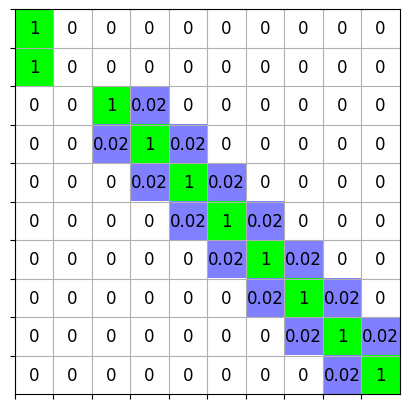

In [3]:
n_dim=10
M = torch.eye(n_dim)
M[1,1]=0
M[1,0]=1

eps_loc = []
for i in range(2, n_dim):
    for j in [i-1, i+1]:
        if j>1 and j<n_dim:
            eps_loc.append((i,j))


eps = 0.02
for loc in eps_loc:
    M[loc] = eps

img = np.zeros((n_dim, n_dim, 3))

for idx, val in np.ndenumerate(M.data.numpy()):
#     print(val)
    if val == 1:
        img[idx] = [0,1,0]
    elif val > 0:
        img[idx] = [0.5,0.5,1]
    else:
        img[idx] = [1,1,1]

fig, ax = plt.subplots()

min_val, max_val, diff = 0., 10., 1.

fig.set_size_inches(5,5)

#imshow portion
N_points = (max_val - min_val) / diff
imshow_data = img
ax.imshow(imshow_data, origin="lower")

#text portion
ind_array = np.arange(min_val, max_val, diff)
x, y = np.meshgrid(ind_array, ind_array)

for x in range(10):
    for y in range(10):
        val = M.data.numpy()[x, y]
        if val == 0:
            c = 0
        elif val == 1:
            c = 1
        else:
            c = "0.02"

        ax.text(y, x, c, va='center', ha='center', fontsize=12)

#set tick marks for grid
ax.set_xticks(np.arange(min_val-diff/2, max_val-diff/2))
ax.set_yticks(np.arange(min_val-diff/2, max_val-diff/2))
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xlim(min_val-diff/2, max_val-diff/2)
ax.set_ylim(max_val-diff/2, min_val-diff/2)
ax.grid()
plt.show()

# Train Agents

In [4]:
np.random.seed(1234)
torch.manual_seed(1234)

In [5]:
n_seeds = 50

pops = 2
t_max = 200
t_add = 0


solo_SP, solo_XP = pop_training(False, n_seeds, t_max, lr=0.05, payoff_matrix=M)

In [6]:
start = time()

div_factor = 0
BR_SP_base, BR_XP_base, pools_base = train_mult_seeds(n_seeds, pops, t_max, t_add, payoff_matrix=M, lr=0.05, div_factor = div_factor )

mid = time()
print(np.round(mid-start, 3), "sec for baseline")

div_factor = 5
BR_SP, BR_XP, pools = train_mult_seeds(n_seeds, pops, t_max, t_add, payoff_matrix=M, lr=0.05, div_factor = div_factor)

end = time()
print(np.round(end-mid, 3), "sec for TrajeDi")

17.804 sec for baseline
18.364 sec for TrajeDi


# Plots

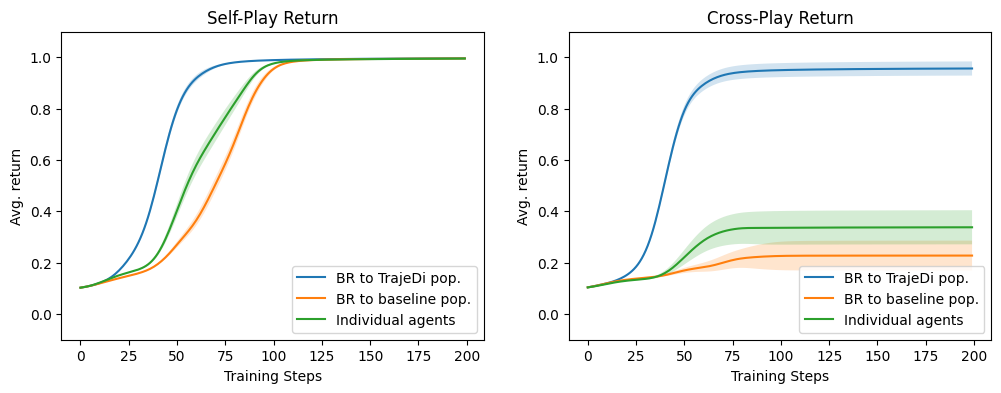

In [7]:
plt.figure(figsize=(12,4))

x = np.arange(BR_SP.shape[1])

plt.subplot(1, 2, 1)
plt.title("Self-Play Return")

# BR to TrajeDi population
m = BR_SP.mean(0)
s = BR_SP.std(0)/np.sqrt(n_seeds)

plt.plot(x, m, label="BR to TrajeDi pop.")
plt.fill_between(x, m+s, m-s, alpha=0.2)

# BR to baseline population
m = BR_SP_base.mean(0)
s = BR_SP_base.std(0)/np.sqrt(n_seeds)

plt.plot(x, m, label="BR to baseline pop.")
plt.fill_between(x, m+s, m-s, alpha=0.2)

# Individual agents
m = solo_SP.mean(0)
s = solo_SP.std(0)/np.sqrt(n_seeds)

plt.plot(x, m, label="Individual agents")
plt.fill_between(x, m+s, m-s, alpha=0.2)

plt.ylabel("Avg. return")
plt.xlabel("Training Steps")

plt.ylim(-0.1, 1.1)
plt.legend(loc="lower right")


# ------------------------------


plt.subplot(1, 2, 2)
plt.title("Cross-Play Return")
# BR to TrajeDi population
m = BR_XP.mean(0)
s = BR_XP.std(0)/np.sqrt(n_seeds)

plt.plot(x, m, label="BR to TrajeDi pop.")
plt.fill_between(x, m+s, m-s, alpha=0.2)

# BR to baseline population
m = BR_XP_base.mean(0)
s = BR_XP_base.std(0)/np.sqrt(n_seeds)

plt.plot(x, m, label="BR to baseline pop.")
plt.fill_between(x, m+s, m-s, alpha=0.2)

# Individual agents
m = solo_XP.mean(0)
s = solo_XP.std(0)/np.sqrt(n_seeds)

plt.plot(x, m, label="Individual agents")
plt.fill_between(x, m+s, m-s, alpha=0.2)

plt.ylabel("Avg. return")
plt.xlabel("Training Steps")

plt.ylim(-0.1, 1.1)
plt.legend(loc="lower right")